<a href="https://colab.research.google.com/github/ariaberlian/rbm_sr/blob/main/rbm_sr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !git clone https://github.com/albertbup/deep-belief-network.git
# !pip install -r "deep-belief-network/requirements.txt"
# !mv "deep-belief-network" "deep_belief_network"
# !pip install pydicom

# """
# - add this to dbn/tensorflow/models.py:
#     import tensorflow._api.v2.compat.v1 as tf
#     tf.disable_v2_behavior()
# """

In [ ]:
import numpy as np
import cv2
import os
# import pydicom
# from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from sklearn.preprocessing import MinMaxScaler
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from matplotlib import gridspec

from deep_belief_network.dbn.tensorflow.models import UnsupervisedDBN # use "from dbn.tensorflow import SupervisedDBNClassification" for computations on TensorFlow

Automatically created module for IPython interactive environment


Instructions for updating:
non-resource variables are not supported in the long term


## Dicom Reader

In [ ]:
# def read_dicom_image(filepath):
#     """
#     Membaca file dicom dan mengembalikan pixel arraynya
#     """
#     # Baca file DICOM
#     dicom_data = pydicom.read_file(filepath)
#     dicom_image_array = None
#     if 'WindowWidth' in dicom_image_array:
#       print('Dataset has windowing')
#       dicom_image_array = apply_voi_lut(dicom_data.pixel_array, dicom_data)
#     else:
#       # Ambil array gambar dari data DICOM
#       dicom_image_array = dicom_data.pixel_array.astype(float)

#     # Rescaling grey scale between 0-255
#     image_2d_scaled = (np.maximum(dicom_image_array,0) / dicom_image_array.max()) * 255.0

#     # Konversi ke format yang dapat diolah oleh OpenCV
#     dicom_image_array = dicom_image_array.astype('uint8')

#     return dicom_image_array


## Downscaler

In [ ]:
# Downscaling Image
import cv2

def downscale_image(image, scale_factor):
    # Menggunakan resize dari OpenCV
    width = int(image.shape[1] * scale_factor)
    height = int(image.shape[0] * scale_factor)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    return resized_image

scale_factor = 0.5

## Image loader

In [ ]:
def load_image(file_path):
    # Muat gambar
    image_cv2 = cv2.imread(file_path)
    img = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    return img

def save_image_as(filename, buffer):
    # save gambar
    cv2.imwrite(filename, buffer)
    print(f"Image {filename} has been saved.")

## Interpolation

In [ ]:
def interpolate(original_image, interpolation_factor):
  """
  Interpolasi bicubic gambar dengan skala interpolation_factor
  """
  # Interpolasi untuk memperbesar gambar
  enlarged_image = cv2.resize(original_image, None, fx=interpolation_factor, fy=interpolation_factor, interpolation=cv2.INTER_CUBIC)

  return enlarged_image

## Visualizer

In [ ]:
def visualize_histogram_compare(original_image, reconstruct_image):
    plt.figure(figsize=(12, 6))

    # Histogram Sebelum Normalisasi
    plt.subplot(2, 2, 1)
    plt.hist(original_image.flatten(), bins=256, range=(0, 256), color='b', alpha=0.5)
    plt.title('Histogram Original Image')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Histogram Sesudah Normalisasi
    plt.subplot(2, 2, 2)
    plt.hist(reconstruct_image.flatten(), bins=256, range=(0, 256), color='r', alpha=0.5)
    plt.title('Histogram Reconstructed Image')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    # Plot Gambar Asli
    plt.subplot(2, 2, 3)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')

    # Plot Hasil Normalisasi
    plt.subplot(2, 2, 4)
    plt.imshow(reconstruct_image, cmap='gray')
    plt.title('Reconstructed Image')

    plt.tight_layout()
    plt.show()

def visualize_histogram(array, title, range=(0, 1), xlabel='Value', ylabel='Frequency'):
    plt.hist(array.flatten(), bins=256, range=range, color='r', alpha=0.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def visualize_patches(patches, title, visualize_size: tuple = (6,6)):
    # visualize patches example
    fig = plt.figure(figsize=(patches.shape[1], patches.shape[2]))
    plt.suptitle(title, fontsize=16)  # Menambahkan judul
    grid = gridspec.GridSpec(visualize_size[0], visualize_size[1], wspace=0.2, hspace=0.2)

    for i in range(visualize_size[0]):
        for j in range(visualize_size[1]):
            # Mengambil patch image
            patch = patches[i * visualize_size[0] + j]

            # Menampilkan patch image tanpa skala
            ax = plt.subplot(grid[i, j])
            ax.imshow(patch)
            ax.axis('off')  # Menyembunyikan sumbu

    plt.show()

def visualize_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.show()

## Pre DBN

In [ ]:
class DataProcessing:
    def __init__(self):
        # Inisialisasi dan fit-transform dengan MinMaxScaler
        self.scaler = MinMaxScaler()

    def dct_transform(self, image):
        # Convert image to float64 for DCT computation
        image_float64 = image.astype(np.float64)

        # Apply 2D DCT on each channel
        dct_result = np.zeros_like(image_float64)
        for channel in range(image.shape[2]):
            dct_result[:, :, channel] = dct(dct(image_float64[:, :, channel], axis=0, norm='ortho'), axis=1, norm='ortho')

        return dct_result

    def idct_transform(self, dct_result):
        # Apply inverse 2D DCT on each channel
        image_restored = np.zeros_like(dct_result)
        for channel in range(dct_result.shape[2]):
            image_restored[:, :, channel] = idct(idct(dct_result[:, :, channel], axis=0, norm='ortho'), axis=1, norm='ortho')

        # Convert the restored image back to uint8
        image_restored = np.clip(image_restored, 0, 255)
        image_restored = image_restored.astype(np.uint8)

        return image_restored

    def _normalize_for_rbm(self, patches):
        """
        Normalisasi gambar untuk dapat dimasukkan ke dalam Restricted Boltzmann Machine (RBM).
        """
        # Perform DCT transform'
        dct_results_list = []
        for patch in patches:
            dct_result = self.dct_transform(patch)
            dct_results_list.append(dct_result)

        dct_results_list = np.array(dct_results_list, dtype=np.float64)
        dct_results_list = dct_results_list.reshape(patches.shape)

        print("dct coeff shape: ", dct_results_list.shape)
        # print("This is after DCT: ")
        # print(dct_results_list[0])
        print("after dct max:", np.max(dct_results_list))
        print("after dct min:", np.min(dct_results_list))


        # Flatten DCT coefficients for normalization
        flattened_dct_coefficients = dct_results_list.reshape(
            patches.shape[0], -1)

        # print("flaten shape: ", flattened_dct_coefficients.shape)

        # Fit-transform using the same scaler instance for all images
        normalized_data = self.scaler.fit_transform(flattened_dct_coefficients)

        # Reshape back to the original form after normalization
        normalized_dct_coefficients = normalized_data.reshape(
            dct_results_list.shape)

        # print("Normalized DCT Coefficients shape: ", normalized_dct_coefficients.shape)
        # print("This is after normalization: ", normalized_dct_coefficients[0])
        # Save minimum and maximum values before normalization

        return normalized_dct_coefficients

    def _zigzag(self, input):
        # initializing the variables
        # ----------------------------------
        h = 0
        v = 0

        vmin = 0
        hmin = 0

        vmax = input.shape[0]
        hmax = input.shape[1]
        channel = input.shape[2]

        # print(vmax ,hmax, channel )

        i = 0

        output = np.zeros((vmax * hmax * channel))
        # ----------------------------------

        while ((v < vmax) and (h < hmax)):
            # print(output)
            # print(f"{v}, {h}")
            if ((h + v) % 2) == 0:                 # going up
                if (v == vmin):
                    # print(1)
                    for c in range(channel):
                        # if we got to the first line
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    if (h == hmax-1):
                        # print("chihuy")
                        v = v + 1
                    else:
                        h = h + 1

                    i = i + 1

                elif ((h == hmax - 1) and (v < vmax)):   # if we got to the last column
                    # print(2)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    v = v + 1
                    i = i + 1

                elif ((v > vmin) and (h < hmax - 1)):    # all other cases
                    # print(3)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    v = v - 1
                    h = h + 1
                    i = i + 1
            else:                                    # going down

                if ((v == vmax - 1) and (h <= hmax - 1)):       # if we got to the last line
                    # print(4)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    h = h + 1
                    i = i + 1

                elif (h == hmin):                  # if we got to the first column
                    # print(5)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1

                    if (v == vmax - 1):
                        h = h + 1
                    else:
                        v = v + 1

                    i = i + 1

                elif ((v < vmax - 1) and (h > hmin)):     # all other cases
                    # print(6)
                    for c in range(channel):
                        output[i+c] = input[v, h, c]
                    i = i + channel - 1
                    v = v + 1
                    h = h - 1
                    i = i + 1

            if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
                # print(7)
                for c in range(channel):
                    output[i+c] = input[v, h, c]
                i = i + channel - 1
                break

        # print ('v:',v,', h:',h,', i:',i)
        return output

    # Inverse zigzag scan of a matrix
    # Arguments are: a 1-by-m*n array,
    # where m & n are vertical & horizontal sizes of an output matrix.
    # Function returns a two-dimensional matrix of defined sizes,
    # consisting of input array items gathered by a zigzag method.
    #
    # Matlab Code:
    # Alexey S. Sokolov a.k.a. nICKEL, Moscow, Russia
    # June 2007
    # alex.nickel@gmail.com

    def _inverse_zigzag(self, input, original_shape: tuple):

        # print input.shape

        # initializing the variables
        # ----------------------------------
        h = 0
        v = 0

        vmin = 0
        hmin = 0

        vmax, hmax, channel = original_shape

        output = np.zeros((vmax, hmax, channel))

        i = 0
        # ----------------------------------

        while ((v < vmax) and (h < hmax)):
            # print ('v:',v,', h:',h,', i:',i)
            if ((h + v) % 2) == 0:                 # going up

                if (v == vmin):
                    # print(1)
                    for c in range(channel):
                        # if we got to the first line
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    if (h == hmax-1):
                        v = v + 1
                    else:
                        h = h + 1

                    i = i + 1

                elif ((h == hmax - 1) and (v < vmax)):   # if we got to the last column
                    # print(2)
                    for c in range(channel):
                        # if we got to the first line
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    v = v + 1
                    i = i + 1

                elif ((v > vmin) and (h < hmax - 1)):    # all other cases
                    # print(3)
                    for c in range(channel):
                        # if we got to the first line
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    v = v - 1
                    h = h + 1
                    i = i + 1

            else:                                    # going down

                if ((v == vmax - 1) and (h <= hmax - 1)):       # if we got to the last line
                    # print(4)
                    for c in range(channel):
                        # if we got to the first line
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    h = h + 1
                    i = i + 1

                elif (h == hmin):                  # if we got to the first column
                    # print(5)
                    for c in range(channel):
                        # if we got to the first line
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    if (v == vmax - 1):
                        h = h + 1
                    else:
                        v = v + 1
                    i = i + 1

                elif ((v < vmax - 1) and (h > hmin)):     # all other cases
                    for c in range(channel):
                        output[v, h, c] = input[i+c]
                    i = i + channel-1
                    v = v + 1
                    h = h - 1
                    i = i + 1

            if ((v == vmax-1) and (h == hmax-1)):          # bottom right element
                # print(7)
                for c in range(channel):
                    # if we got to the first line
                    output[v, h, c] = input[i+c]
                i = i + channel-1
                break

        return output

    def preprocess_for_rbm(self, images):
        """
        Persiapkan data untuk dimasukkan ke dalam RBM.
        Image di normalisasi dengan dct sehingga dalam domain frekuensi dengan rentang [0,1]

        Input: patch images
        Output: flatten arrays: array-like (Number of patch images, (patch.shape[0] * patch.shape[1] * patch.shape[2]))
        """

        # Normalisasi gambar untuk RBM
        normalized_coefficients = self._normalize_for_rbm(images)

        # Flattening hasil untuk masukan RBM
        flattened_dct_coefficients = [self._zigzag(
            coeff) for coeff in normalized_coefficients]
        flattened_dct_coefficients = np.asarray(
            flattened_dct_coefficients, dtype=np.float64)

        # print("Ready for rbm array shape: ", flattened_dct_coefficients.shape)
        # print("This is after zigzag:")
        # print(flattened_dct_coefficients[0])
        return flattened_dct_coefficients

    def inverse_preprocess(self, coefficients, original_patch_shape):
        """
        Mengembalikan inverse koefisien DCT yang dinormalisasi ke gambar asli dengan inverse langkah zigzag

        Input: coefficients: array-like (Number of patch images, (patch.shape[0] * patch.shape[1] * patch.shape[2]))
        """

        # Reshape ke bentuk yang sesuai dengan gambar asli
        reshaped_coefficients = [self._inverse_zigzag(
            coef, original_patch_shape) for coef in coefficients]
        reshaped_coefficients = np.asarray(
            reshaped_coefficients, dtype=np.float64)

        # print("After inverse zigzag shape: ", reshaped_coefficients.shape)
        # print("this is after inverse zigzag:")
        # print(reshaped_coefficients[0])

        # Denormalisasi nilai koefisien
        denormalized_coefficients = self.scaler.inverse_transform(
            reshaped_coefficients.reshape(reshaped_coefficients.shape[0], -1))

        # Reshape kembali ke bentuk asli setelah normalisasi
        denormalized_coefficients = denormalized_coefficients.reshape(
            reshaped_coefficients.shape)

        print("Denormalized coeffients array shape: ", denormalized_coefficients.shape)
        # print("This is after denormalize:")
        # # print(denormalized_coefficients[0])
        print("before idct max:", np.max(denormalized_coefficients))
        print("before idct min:", np.min(denormalized_coefficients))

        # Perform inverse DCT transform
        restored_images_list = []
        for res in denormalized_coefficients:
            restored_image = self.idct_transform(res)
            restored_images_list.append(restored_image)

        restored_images_list = np.array(restored_images_list, dtype=np.uint8)
        restored_images_list = restored_images_list.reshape(denormalized_coefficients.shape)

        return restored_images_list

    def get_patches(self, input_image: np.ndarray, patch_size: tuple = (16, 16), stride: tuple = (4, 4)):
        """
        Ambil patch dari input_image dengan ukuran patch_size dan langkah sejauh stride
        """
        patches = []

        i = j = 0
        height, width, channels = input_image.shape[0], input_image.shape[1], input_image.shape[2]

        while i + patch_size[0] <= height:
            j = 0
            while j + patch_size[1] <= width:
                if i + patch_size[0] <= height and j + patch_size[1] <= width:
                    patches.append(
                        input_image[i:i+patch_size[0], j:j+patch_size[1], :])
                j += stride[1]
            i += stride[0]

        print("Jumlah Patches = ", len(patches))
        patches = np.asarray(patches).reshape(-1,
                                              patch_size[0], patch_size[1], channels)
        # visualize_patches(patches, (8,8))
        return np.asarray(patches).reshape(-1, patch_size[0], patch_size[1], channels)

    def reconstruct_from_patches(self, patches, original_shape, patch_size=(16, 16), stride=(4, 4)):
        """
        Rekonstruksi gambar utuh dari patches.
        """
        height, width, channels = original_shape
        num_rows = (height - patch_size[0]) // stride[0] + 1
        num_cols = (width - patch_size[1]) // stride[1] + 1

        reconstructed_image = np.zeros(
            (height, width, channels), dtype=np.float64)
        count_matrix = np.zeros((height, width, channels), dtype=np.float64)

        patch_idx = 0
        for i in range(num_rows):
            for j in range(num_cols):
                start_row, start_col = i * stride[0], j * stride[1]
                end_row, end_col = start_row + \
                    patch_size[0], start_col + patch_size[1]
                reconstructed_image[start_row:end_row,
                                    start_col:end_col, :] += patches[patch_idx]
                count_matrix[start_row:end_row, start_col:end_col, :] += 1
                patch_idx += 1

        # Normalisasi dengan membagi dengan jumlah kontribusi setiap patch
        reconstructed_image /= count_matrix

        # Pastikan tipe data akhir sesuai dengan kebutuhan
        return reconstructed_image.astype(np.uint8)


## DBN

### Training

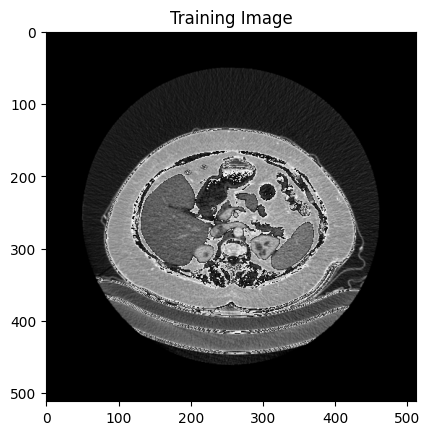

Jumlah Patches =  15625


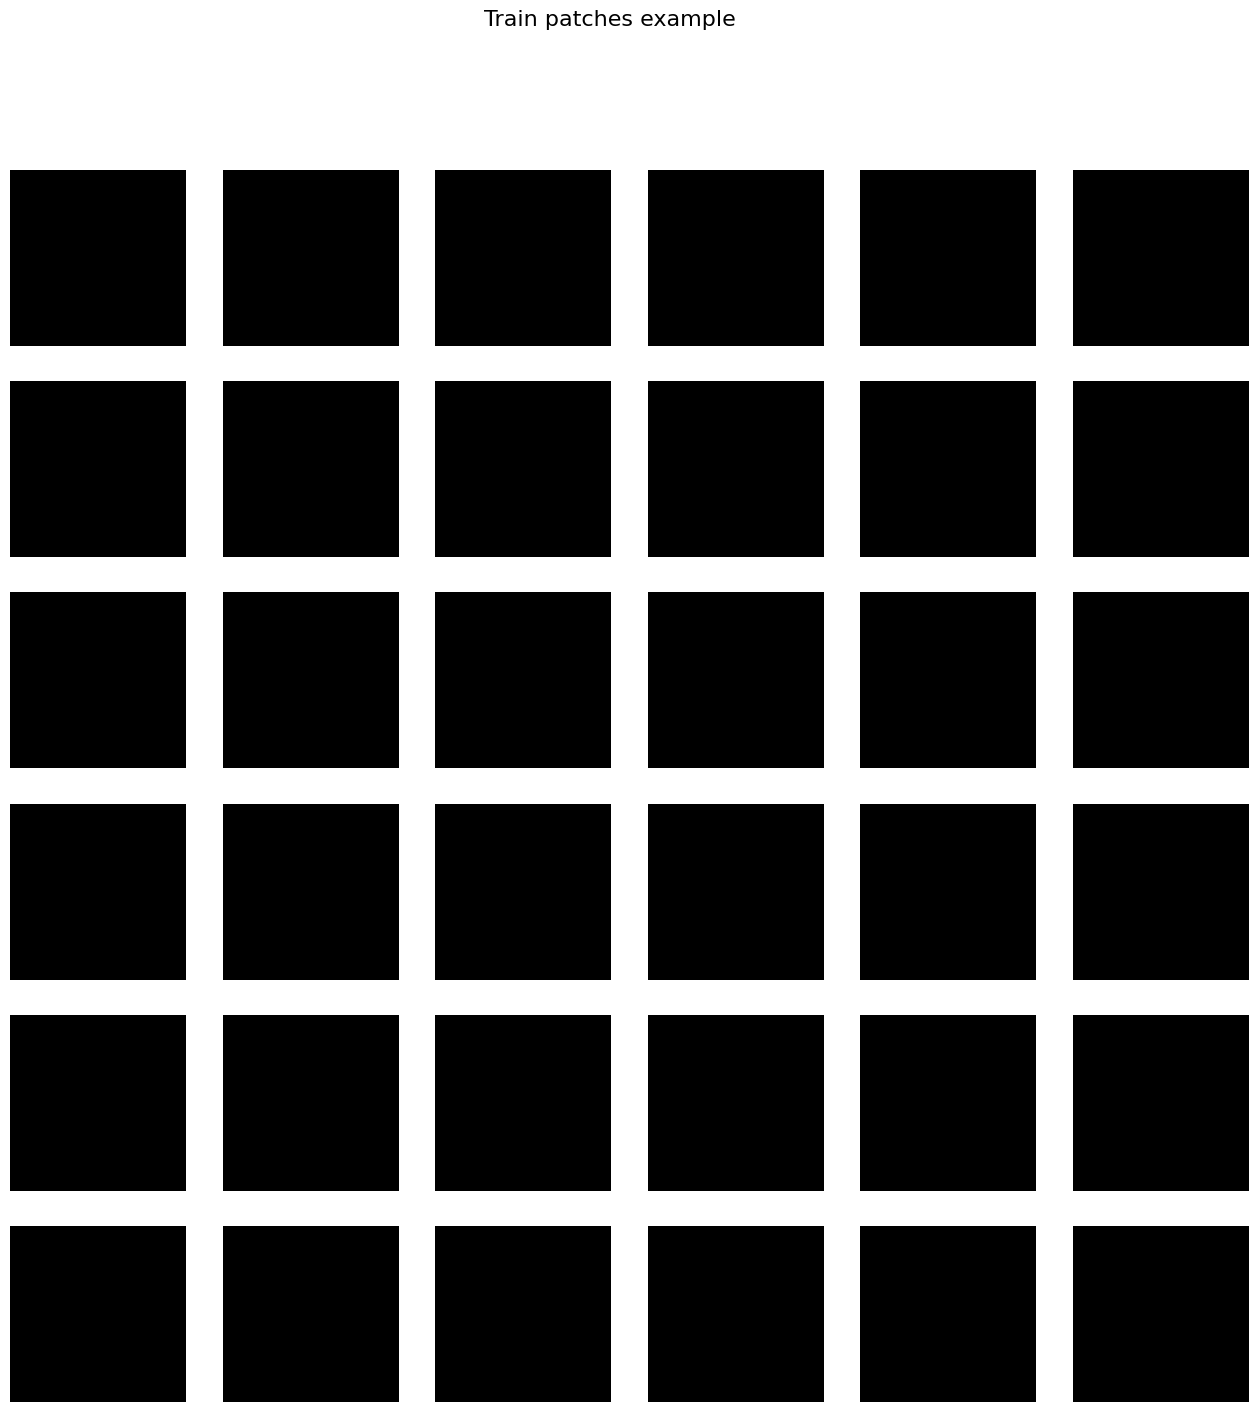

dct coeff shape:  (15625, 16, 16, 3)
after dct max: 2996.1875000000014
after dct min: -1013.710469599308


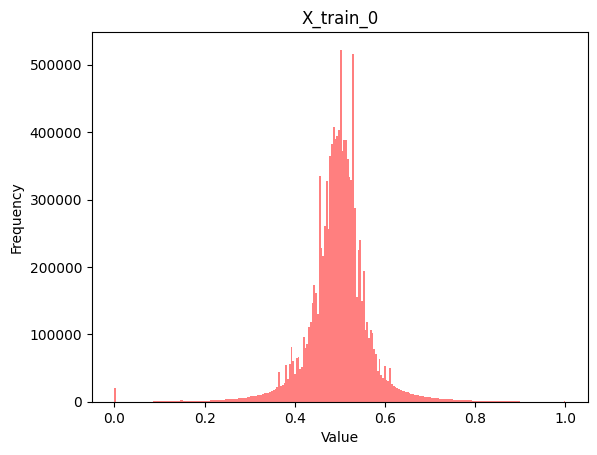

In [ ]:
# Load Data
dp = DataProcessing()

training_image = load_image("/content/drive/MyDrive/rbm_sr_data/lung_train1.png")
visualize_image(training_image, "Training Image")

train_patches = dp.get_patches(training_image)
visualize_patches(train_patches, "Train patches example")

X_train = dp.preprocess_for_rbm(train_patches)
visualize_histogram(X_train, title="X_train_0")

In [ ]:
def proccess_output(u, r, beta, s):
  I = len(u)
  for i in range(I):
    if i>=(I/s):
      u[i] = beta*r[i]
  return u

# ###############################################################################
interpolation_factor = 2
beta = 1.5
Q = 2
lr = 0.01
epoch = 50
layers = [400,200,768]
batch_size = 128
activation_function = 'sigmoid'

# Models we will use
dbn = UnsupervisedDBN(hidden_layers_structure=layers,
                      batch_size=batch_size,
                      learning_rate_rbm=lr,
                      n_epochs_rbm=epoch,
                      activation_function=activation_function)


# ###############################################################################
# Training RBM
q = 1
dbn.fit(X_train)
dbn.save("/content/drive/MyDrive/rbm_sr_data/model_1.h5")
while q < Q:
  print("q saat ini: ", q)
  dbn = dbn.load(f"/content/drive/MyDrive/rbm_sr_data/model_{q}.h5")
  r = dbn.transform(X_train)
  X_train = proccess_output(X_train, r, beta, interpolation_factor)
  visualize_histogram(X_train, title=f"X_train_{q}")
  dbn.fit(X_train)
  dbn.save(f"/content/drive/MyDrive/rbm_sr_data/model_{q+1}.h5")
  q += 1

Instructions for updating:
Use `tf.cast` instead.


[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 4.721580
>> Epoch 2 finished 	RBM Reconstruction error 3.544944
>> Epoch 3 finished 	RBM Reconstruction error 3.145295
>> Epoch 4 finished 	RBM Reconstruction error 2.931145
>> Epoch 5 finished 	RBM Reconstruction error 2.802884
>> Epoch 6 finished 	RBM Reconstruction error 2.738452
>> Epoch 7 finished 	RBM Reconstruction error 2.630557
>> Epoch 8 finished 	RBM Reconstruction error 2.590535
>> Epoch 9 finished 	RBM Reconstruction error 2.558342
>> Epoch 10 finished 	RBM Reconstruction error 2.547717
>> Epoch 11 finished 	RBM Reconstruction error 2.526114
>> Epoch 12 finished 	RBM Reconstruction error 2.516471
>> Epoch 13 finished 	RBM Reconstruction error 2.510986
>> Epoch 14 finished 	RBM Reconstruction error 2.522395
>> Epoch 15 finished 	RBM Reconstruction error 2.505288
>> Epoch 16 finished 	RBM Reconstruction error 2.495008
>> Epoch 17 finished 	RBM Reconstruction error 2.498998
>> Epoch 18 finished 	RBM Reco

### Testing

In [ ]:
# Test dengan data training
test = dbn.predict(X_train)
test_patches = dp.inverse_preprocess(test, (16,16,3))

visualize_patches(train_patches, "Train Patches Example")
visualize_patches(test_patches, "Test Patches Example")

reconstruct_image = dp.reconstruct_from_patches(test_patches)

visualize_histogram_compare(training_image, reconstruct_image)

### Scoring

In [ ]:
# Scoring
def calculate_psnr(original_image, enhanced_image):
    psnr_value = peak_signal_noise_ratio(original_image, enhanced_image)
    return psnr_value

def calculate_ssim(original_image, enhanced_image):
    # Inisialisasi variabel untuk menyimpan nilai SSIM untuk setiap channel
    ssim_values = []

    # Iterasi melalui setiap channel
    for channel in range(original_image.shape[2]):
        # Hitung SSIM untuk setiap channel
        ssim_channel, _ = structural_similarity(original_image[:, :, channel], enhanced_image[:, :, channel], full=True)

        # Tambahkan nilai SSIM ke dalam list
        ssim_values.append(ssim_channel)

    # Hitung rata-rata SSIM untuk semua channel
    average_ssim = np.mean(ssim_values)

    return average_ssim

# print("PSNR value: ", calculate_psnr(result, reslow))
# print("SSIM value: ", calculate_ssim(result, reslow))